In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import stat
import glob
import os
from tabulate import tabulate
from datetime import datetime
from sklearn.metrics import make_scorer, precision_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
import sweetviz as sv

!pip install sweetviz
!pip install pipelinehelper
drive.mount('/content/drive')

     |████████████████████████████████| 15.1 MB 154 kB/s 
Mounted at /content/drive


# Data Cleaning
Reading in data from Google Drive location, concatentating, and converting from long to wide. 
Dropping and renaming columns, and changing data types to floats. 

In [2]:
os.chdir("/content/drive/MyDrive/Capstone/data")

extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

data_long = pd.concat([pd.read_csv(f) for f in all_filenames])

In [3]:
display(data_long)

,series,timestamp,value,label
0,A,2020-01-06T08:02:00.000Z,8.051282,NaN
1,B,2020-01-06T08:02:00.000Z,95.607216,NaN
2,C,2020-01-06T08:02:00.000Z,95.205727,NaN
3,D,2020-01-06T08:02:00.000Z,94.656235,NaN
4,E,2020-01-06T08:02:00.000Z,93.324806,NaN
...,...,...,...,...
4195,A,2021-07-15T13:21:52.000Z,1.149620,NaN
4196,B,2021-07-15T13:21:52.000Z,78.799957,NaN
4197,C,2021-07-15T13:21:52.000Z,74.682655,NaN
4198,D,2021-07-15T13:21:52.000Z,64.971161,NaN


In [4]:
data = data_long.pivot(index='timestamp', columns='series', values=['value', 'label'])

In [5]:
display(data)

value                    ... label          
series                          A        B        C  ...     C    D    E
timestamp                                            ...                
2020-01-06T08:02:00.000Z  8.05128  95.6072  95.2057  ...   NaN  NaN  NaN
2020-01-06T08:03:40.000Z  27.9459  95.5861   95.248  ...   NaN  NaN  NaN
2020-01-06T08:05:20.000Z  25.9158  95.6072  95.2269  ...   NaN  NaN  NaN
2020-01-06T08:07:00.000Z  35.6603  95.5861  95.2057  ...   NaN  NaN  NaN
2020-01-06T08:08:40.000Z  23.0737  95.6072  95.2057  ...   NaN  NaN  NaN
...                           ...      ...      ...  ...   ...  ...  ...
2021-07-15T11:36:12.000Z  3.58536  97.6995  107.847  ...   NaN  NaN  NaN
2021-07-15T11:36:22.000Z  3.58536  97.6995  107.847  ...   NaN  NaN  NaN
2021-07-15T13:21:32.000Z  1.14962     78.8  74.6827  ...   NaN  NaN  NaN
2021-07-15T13:21:42.000Z  1.14962     78.8  74.6827  ...   NaN  NaN  NaN
2021-07-15T13:21:52.000Z  1.14962     78.8  74.6827  ...   NaN  NaN  NaN

[176255 rows x 10 columns]

In [6]:
data.columns = ['A', 'B', 'C', 'D', 'E', 'label', 'label_B', 'label_C', 'label_D', 'label_E']
display(data)

,A,B,C,D,E,label,label_B,label_C,label_D,label_E
timestamp,,,,,,,,,,
2020-01-06T08:02:00.000Z,8.05128,95.6072,95.2057,94.6562,93.3248,NaN,NaN,NaN,NaN,NaN
2020-01-06T08:03:40.000Z,27.9459,95.5861,95.248,94.6985,93.3459,NaN,NaN,NaN,NaN,NaN
2020-01-06T08:05:20.000Z,25.9158,95.6072,95.2269,94.6774,93.3671,NaN,NaN,NaN,NaN,NaN
2020-01-06T08:07:00.000Z,35.6603,95.5861,95.2057,94.6562,93.3459,NaN,NaN,NaN,NaN,NaN
2020-01-06T08:08:40.000Z,23.0737,95.6072,95.2057,94.6562,93.3882,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2021-07-15T11:36:12.000Z,3.58536,97.6995,107.847,121.392,129.028,NaN,NaN,NaN,NaN,NaN
2021-07-15T11:36:22.000Z,3.58536,97.6995,107.847,121.392,129.028,NaN,NaN,NaN,NaN,NaN
2021-07-15T13:21:32.000Z,1.14962,78.8,74.6827,64.9712,57.1462,NaN,NaN,NaN,NaN,NaN


In [7]:
data['timestamp'] = data.index
data = data.reset_index(drop=True)
data = data.sort_values(by='timestamp')
display(data)

,A,B,C,D,E,label,label_B,label_C,label_D,label_E,timestamp
0,8.05128,95.6072,95.2057,94.6562,93.3248,NaN,NaN,NaN,NaN,NaN,2020-01-06T08:02:00.000Z
1,27.9459,95.5861,95.248,94.6985,93.3459,NaN,NaN,NaN,NaN,NaN,2020-01-06T08:03:40.000Z
2,25.9158,95.6072,95.2269,94.6774,93.3671,NaN,NaN,NaN,NaN,NaN,2020-01-06T08:05:20.000Z
3,35.6603,95.5861,95.2057,94.6562,93.3459,NaN,NaN,NaN,NaN,NaN,2020-01-06T08:07:00.000Z
4,23.0737,95.6072,95.2057,94.6562,93.3882,NaN,NaN,NaN,NaN,NaN,2020-01-06T08:08:40.000Z
...,...,...,...,...,...,...,...,...,...,...,...
176250,3.58536,97.6995,107.847,121.392,129.028,NaN,NaN,NaN,NaN,NaN,2021-07-15T11:36:12.000Z
176251,3.58536,97.6995,107.847,121.392,129.028,NaN,NaN,NaN,NaN,NaN,2021-07-15T11:36:22.000Z
176252,1.14962,78.8,74.6827,64.9712,57.1462,NaN,NaN,NaN,NaN,NaN,2021-07-15T13:21:32.000Z
176253,1.14962,78.8,74.6827,64.9712,57.1462,NaN,NaN,NaN,NaN,NaN,2021-07-15T13:21:42.000Z


In [8]:
data.describe()

,A,B,C,D,E,label,label_B,label_C,label_D,label_E,timestamp
count,176255.000000,176255.000000,176255.000000,176255.000000,176255.000000,101686,0,0,0,0,176255
unique,13899.000000,5259.000000,5543.000000,5432.000000,4832.000000,1,0,0,0,0,176255
top,2.367096,95.564964,112.264168,125.892929,119.410217,label_1,NaN,NaN,NaN,NaN,2021-02-24T13:26:28.000Z
freq,453.000000,310.000000,216.000000,258.000000,245.000000,101686,NaN,NaN,NaN,NaN,1


In [9]:
data.drop(['label_B', 'label_C', 'label_D', 'label_E'], axis=1, inplace=True)
data.describe()

,A,B,C,D,E,label,timestamp
count,176255.000000,176255.000000,176255.000000,176255.000000,176255.000000,101686,176255
unique,13899.000000,5259.000000,5543.000000,5432.000000,4832.000000,1,176255
top,2.367096,95.564964,112.264168,125.892929,119.410217,label_1,2021-02-24T13:26:28.000Z
freq,453.000000,310.000000,216.000000,258.000000,245.000000,101686,1


In [10]:
# change label to be binary 
# np.NaN == 0
# "label_1" == 1

data['label'] = data['label'].map({np.NaN: 0, 'label_1': 1})

In [11]:
display(data)

,A,B,C,D,E,label,timestamp
0,8.05128,95.6072,95.2057,94.6562,93.3248,0,2020-01-06T08:02:00.000Z
1,27.9459,95.5861,95.248,94.6985,93.3459,0,2020-01-06T08:03:40.000Z
2,25.9158,95.6072,95.2269,94.6774,93.3671,0,2020-01-06T08:05:20.000Z
3,35.6603,95.5861,95.2057,94.6562,93.3459,0,2020-01-06T08:07:00.000Z
4,23.0737,95.6072,95.2057,94.6562,93.3882,0,2020-01-06T08:08:40.000Z
...,...,...,...,...,...,...,...
176250,3.58536,97.6995,107.847,121.392,129.028,0,2021-07-15T11:36:12.000Z
176251,3.58536,97.6995,107.847,121.392,129.028,0,2021-07-15T11:36:22.000Z
176252,1.14962,78.8,74.6827,64.9712,57.1462,0,2021-07-15T13:21:32.000Z
176253,1.14962,78.8,74.6827,64.9712,57.1462,0,2021-07-15T13:21:42.000Z


In [12]:
data.describe()

,label
count,176255.000000
mean,0.576925
std,0.494048
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [13]:
dtype_map = {'A': 'int64',
             'B': 'int64',
             'C': 'int64',
             'D': 'int64',
             'E': 'int64',
             'label': 'int64'}
data = data.astype(dtype_map)


In [14]:
data.dtypes

A             int64
B             int64
C             int64
D             int64
E             int64
label         int64
timestamp    object
dtype: object

In [15]:
data.corr()

,A,B,C,D,E,label
A,1.000000,0.110385,0.244366,0.470540,0.550293,0.342910
B,0.110385,1.000000,0.803760,0.713637,0.636006,0.109095
C,0.244366,0.803760,1.000000,0.917888,0.823834,0.161844
D,0.470540,0.713637,0.917888,1.000000,0.948744,0.276491
E,0.550293,0.636006,0.823834,0.948744,1.000000,0.359586
label,0.342910,0.109095,0.161844,0.276491,0.359586,1.000000


# EDA
Using Sweetviz to automate the exploratory data analysis portion. 

                                             |          | [  0%]   00:00 -> (? left)


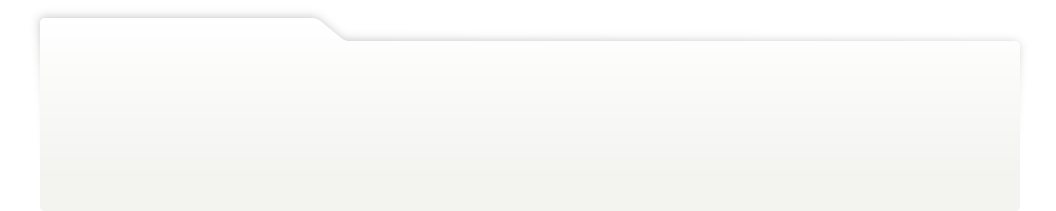
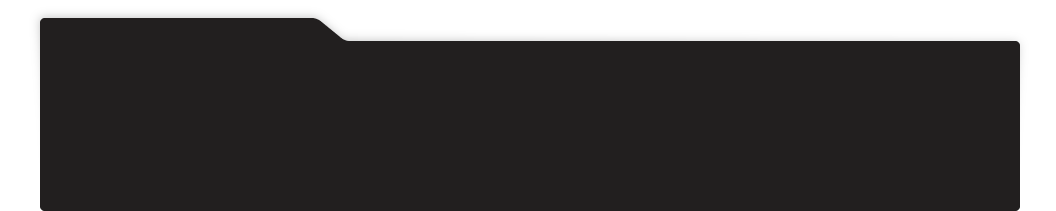
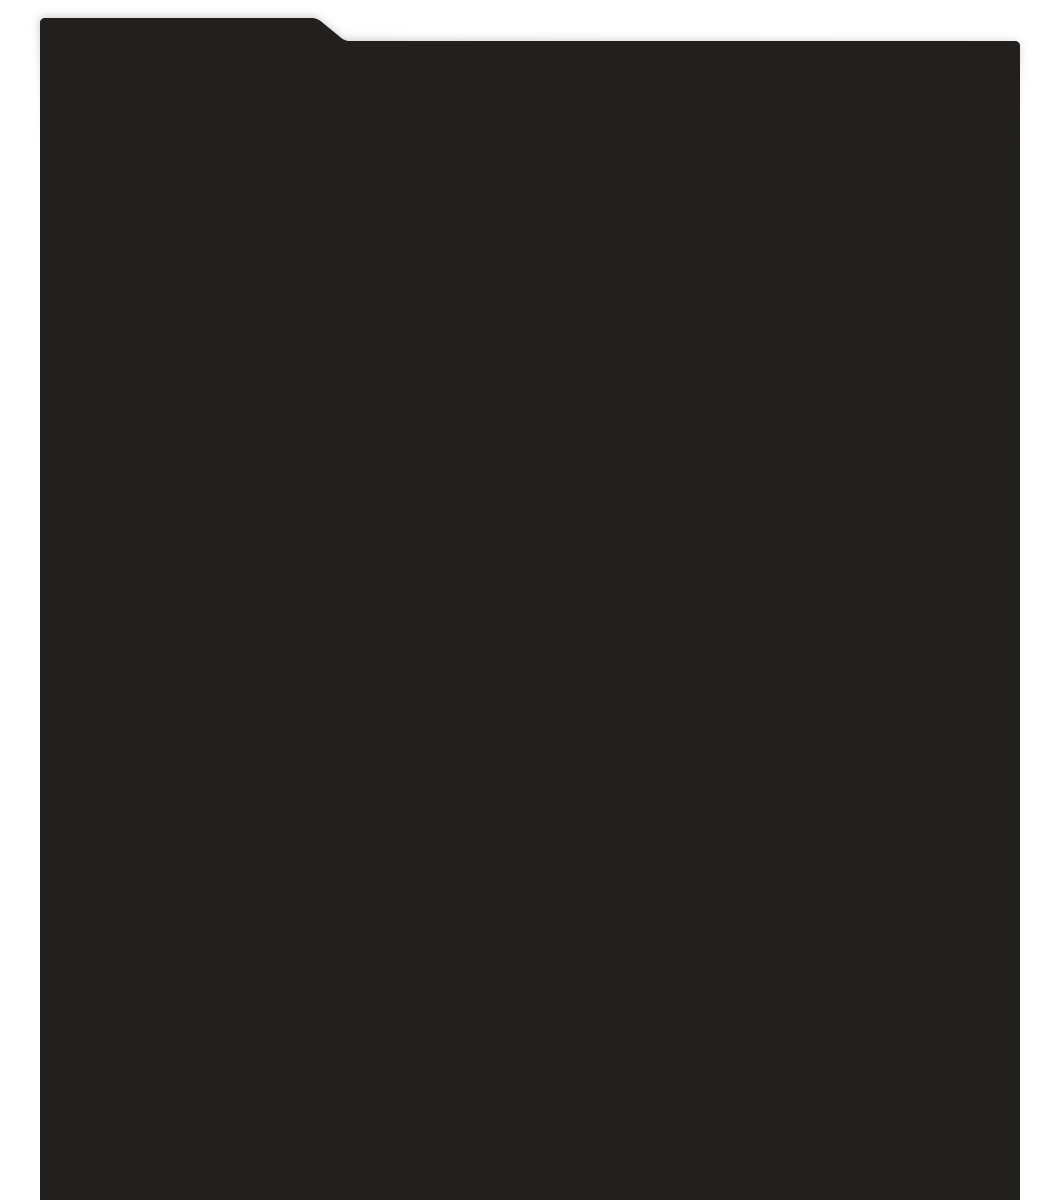
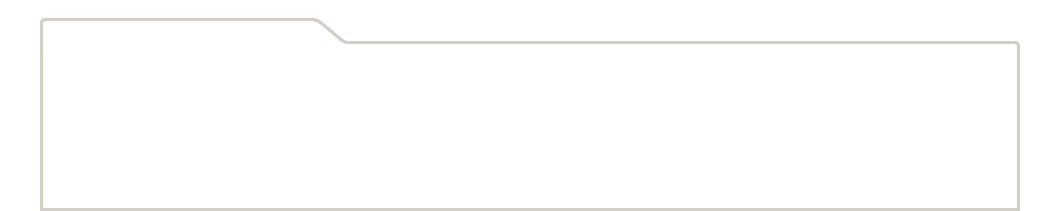
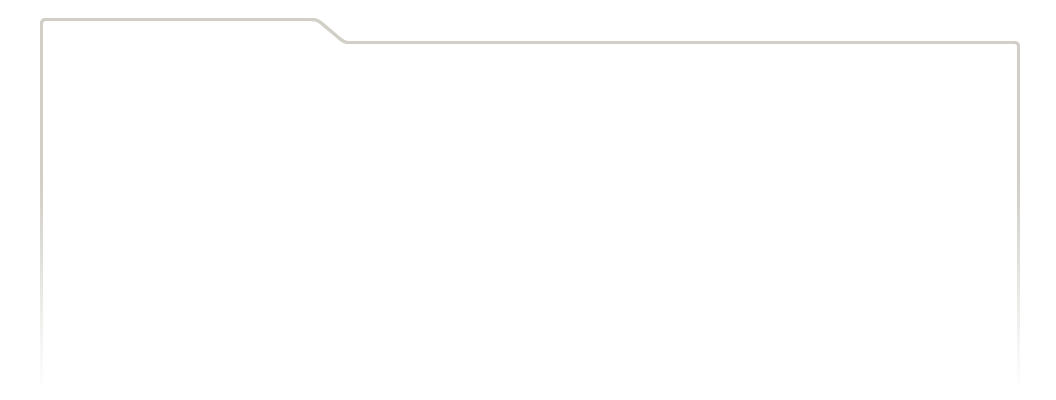
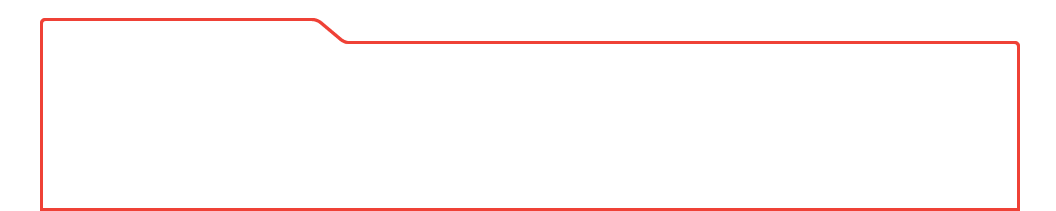
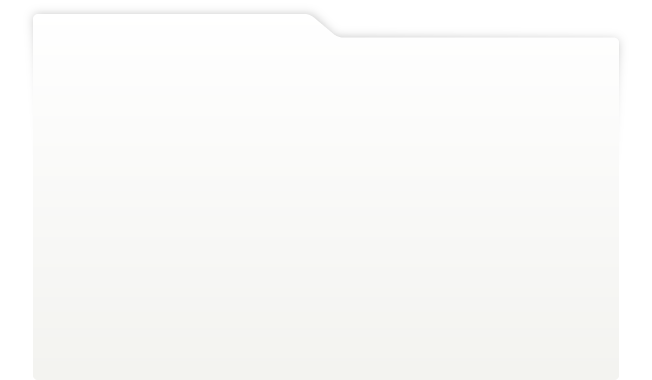
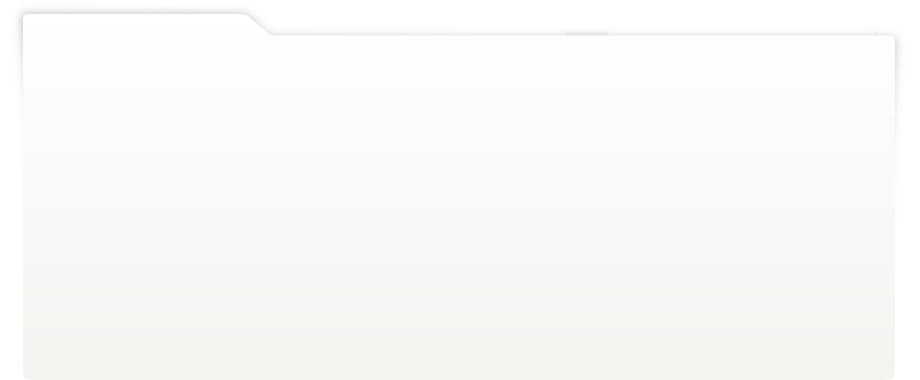
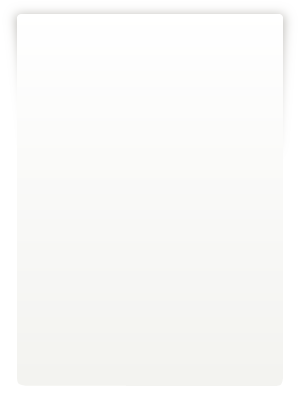
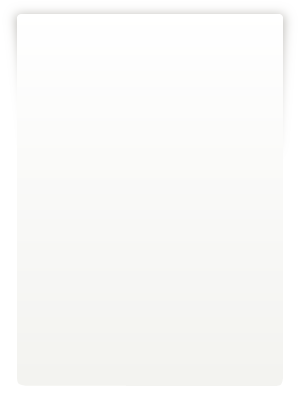
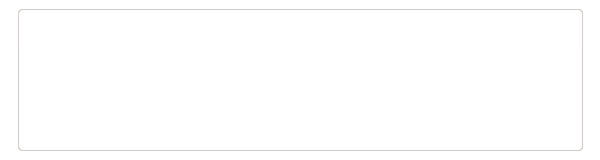
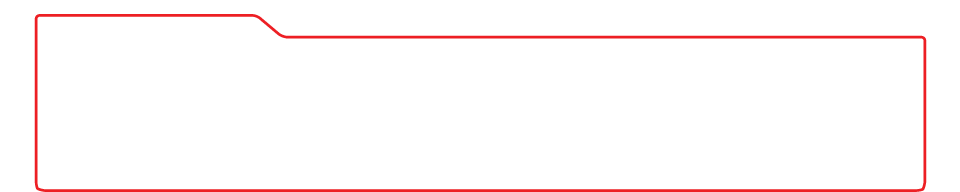
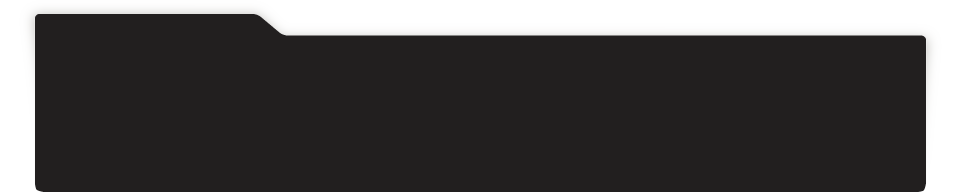
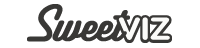
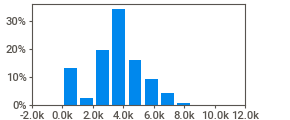
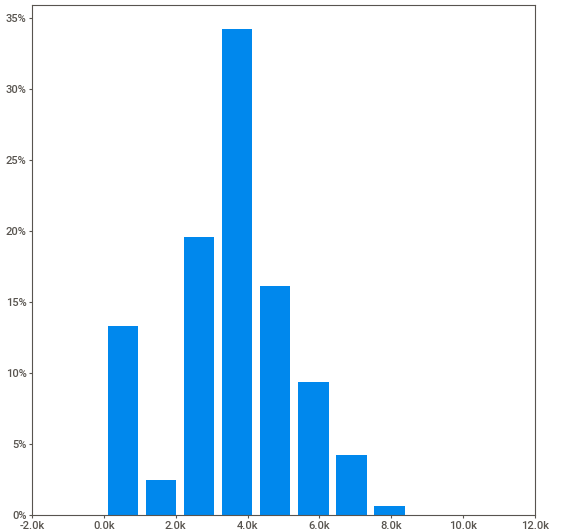
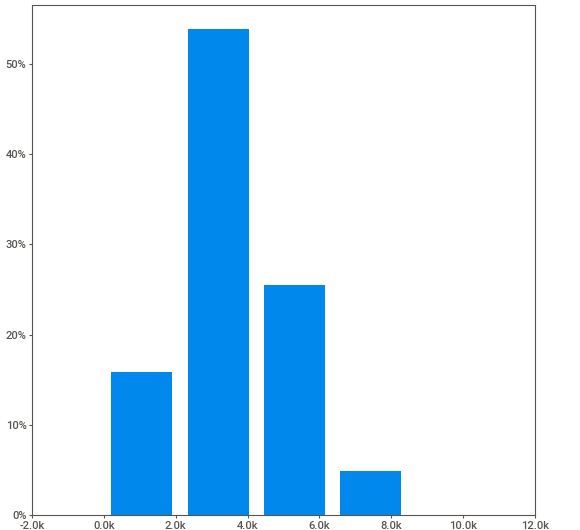
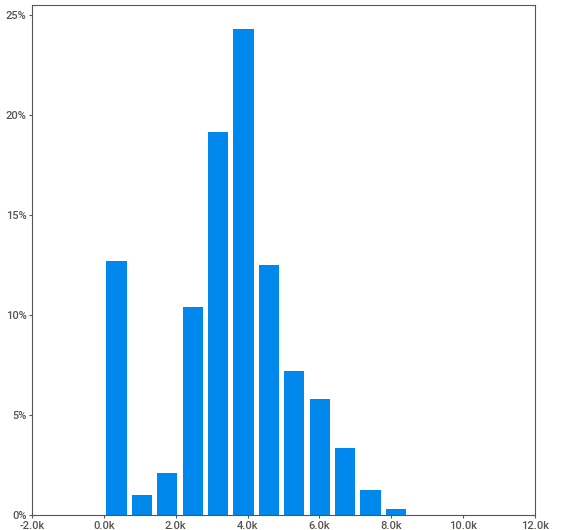
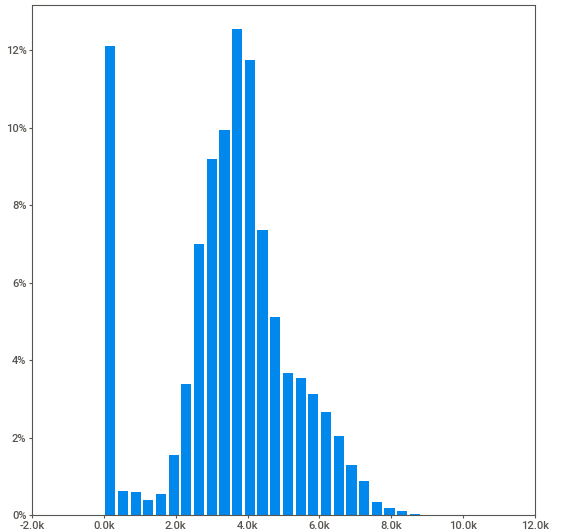
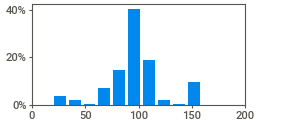
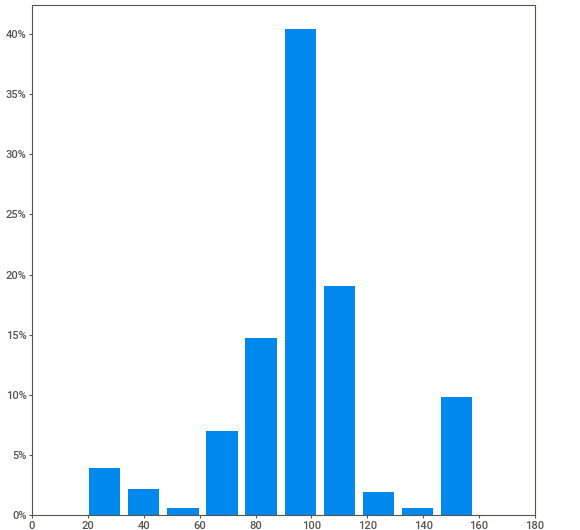
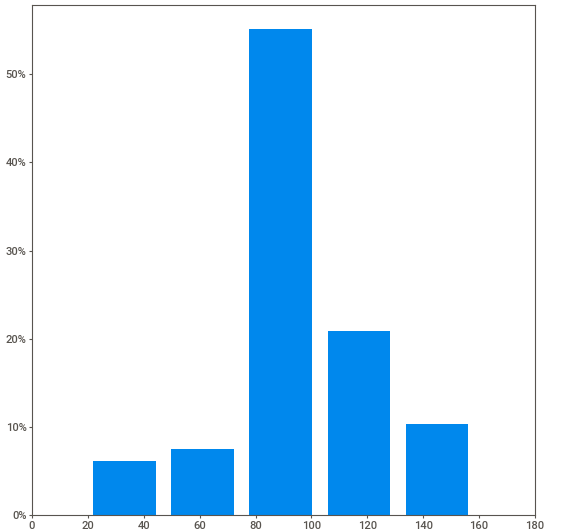
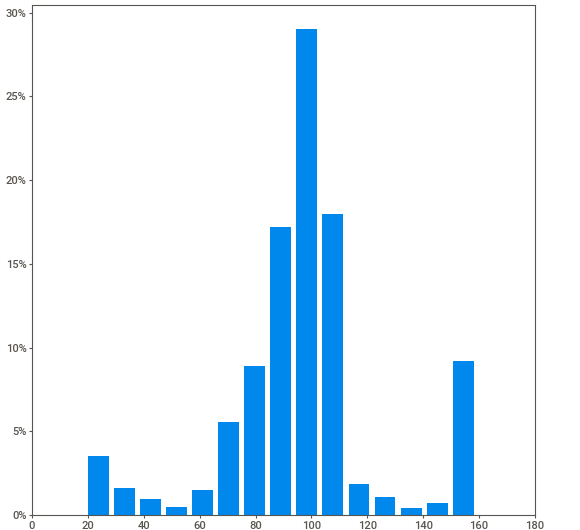
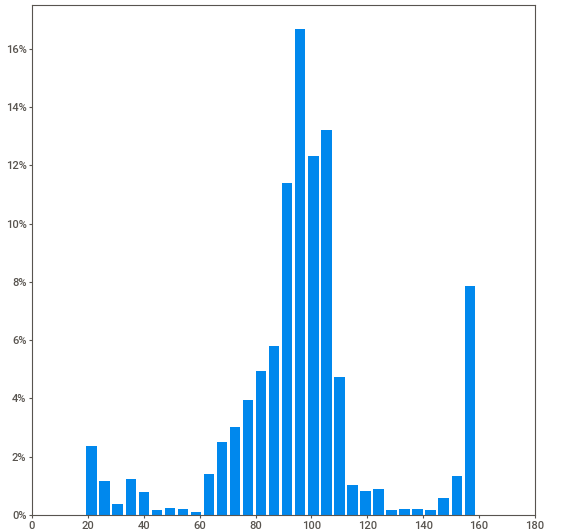
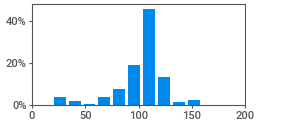
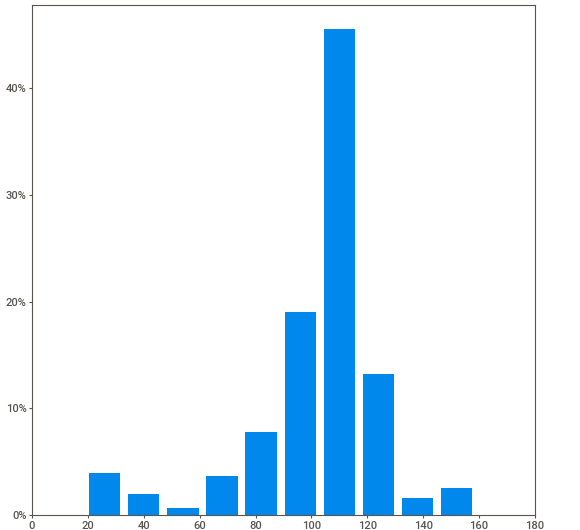
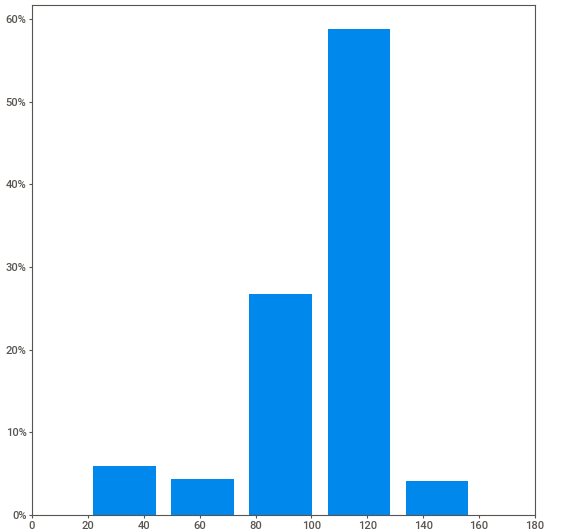
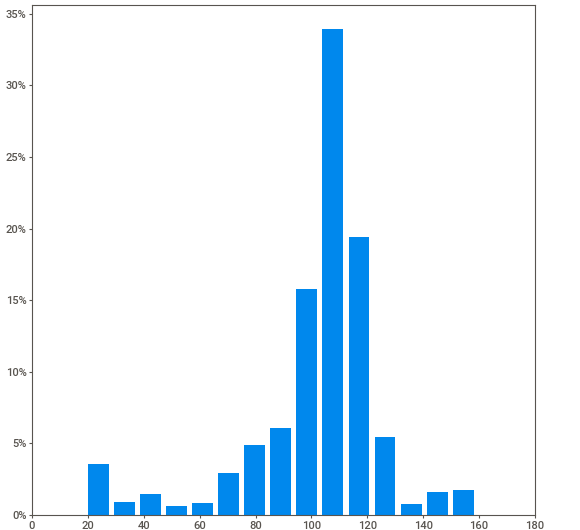
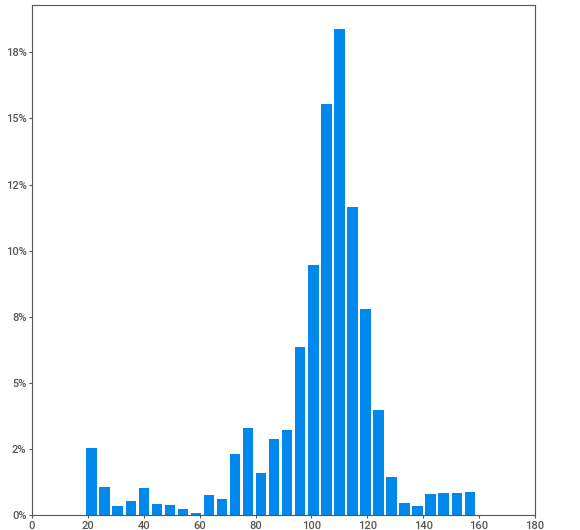
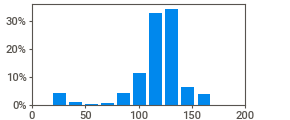
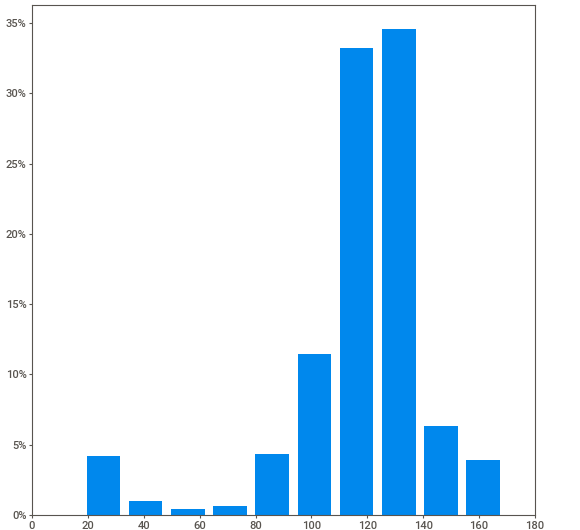
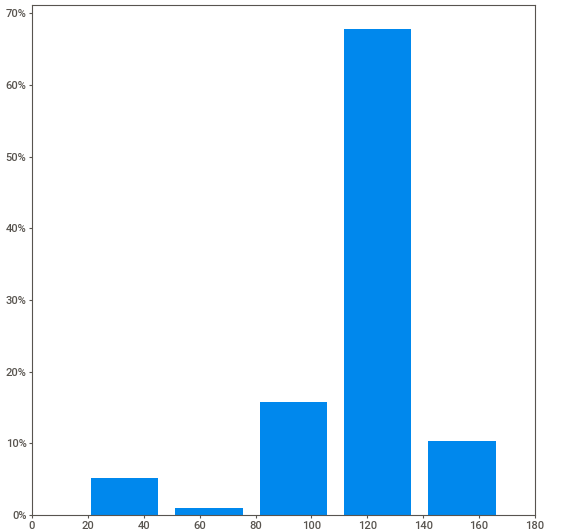
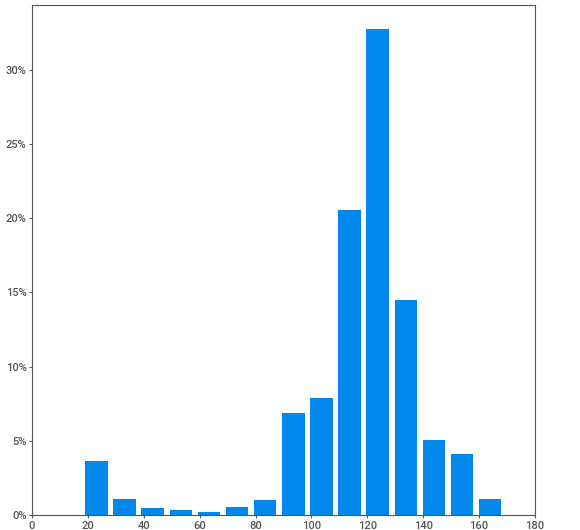
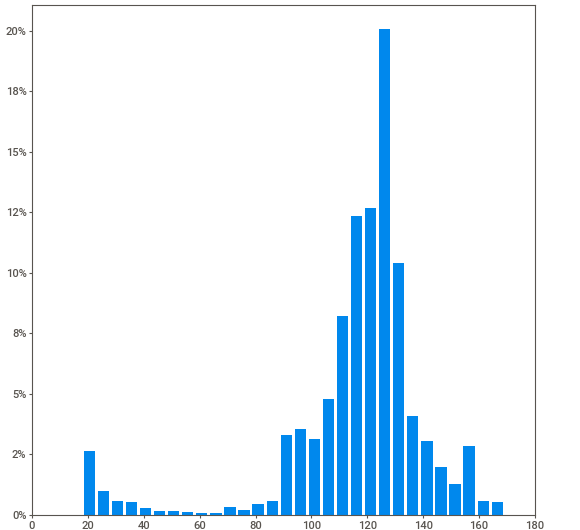
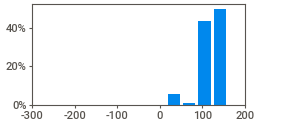
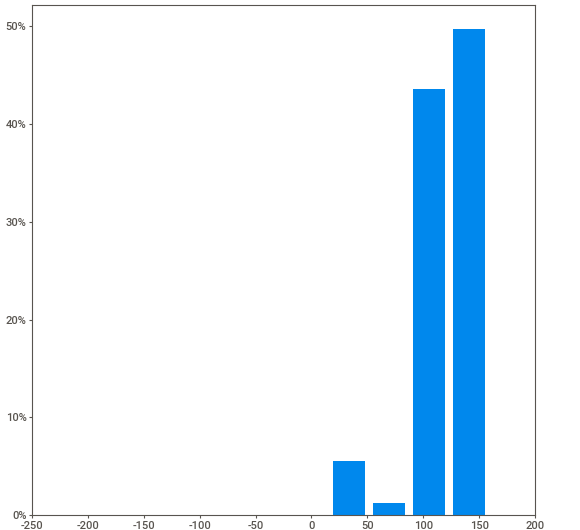
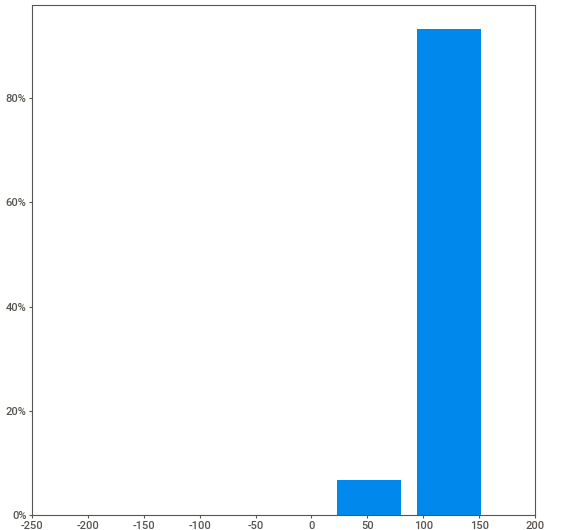
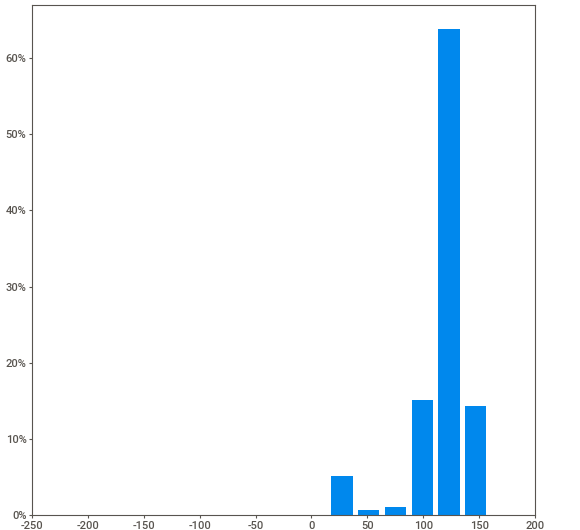
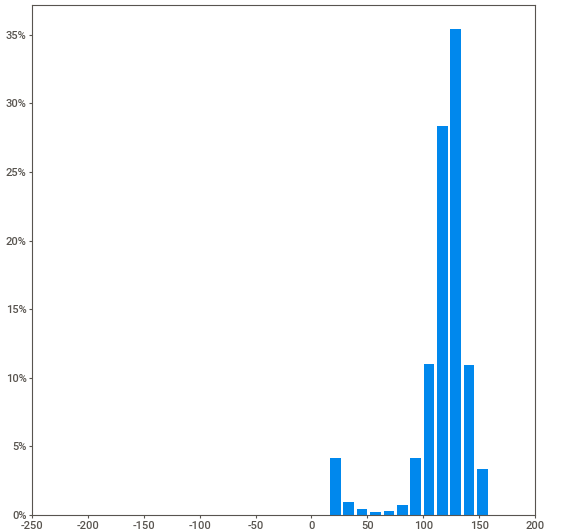
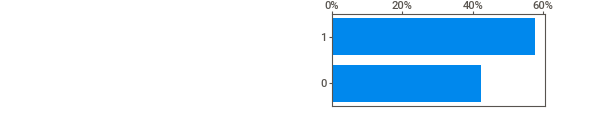
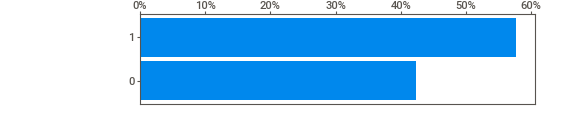
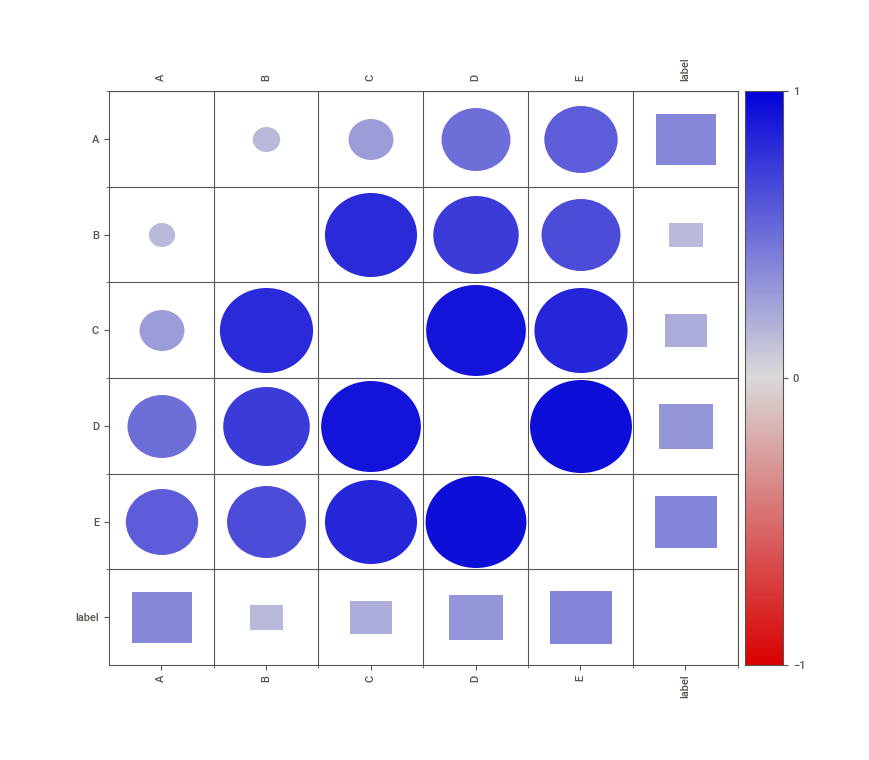
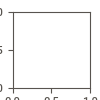

In [50]:
report = sv.analyze(data)
report.show_notebook(layout='vertical')

# Data Preprocessing and Feature Engineering
Creates training, testing, and validation sets using a window.
Preprocessing includes standardization of the features.
Feature engineerings includes creating PCA features and second order interaction terms. 


In [16]:
# create train, test, and validation data sets
# splits are by specific dates to avoid data leakage
# since data is time dependent

train = data[data['timestamp'] < '2021-04-19T09:30:00.000Z']
valid = data[(data['timestamp'] >= '2021-04-19T09:30:00.000Z') & (data['timestamp'] < '2021-06-01T11:03:30.000Z')]
test = data[data['timestamp'] >= '2021-06-01T11:03:30.000Z']

x_features = ['A', 'B', 'C', 'D', 'E', 'timestamp']
y_feature = ['label']
X_train, X_test, X_valid = train[x_features], test[x_features], valid[x_features]
y_train, y_test, y_valid = train[y_feature], test[y_feature], valid[y_feature]

In [17]:
# take a peek at the different sets
n_train =len(X_train)
n_test = len(X_test)
n_valid = len(X_valid)

print(n_train, 'training samples with dates', X_train['timestamp'].iloc[0], 'to', X_train['timestamp'].iloc[(n_train-1)])
print(n_valid, 'validation samples with dates', X_valid['timestamp'].iloc[0], 'to', X_valid['timestamp'].iloc[(n_valid-1)])
print(n_test, 'testing samples with dates', X_test['timestamp'].iloc[0], 'to', X_test['timestamp'].iloc[(n_test-1)])

121472 training samples with dates 2020-01-06T08:02:00.000Z to 2021-04-13T13:42:21.000Z
26600 validation samples with dates 2021-04-19T09:30:00.000Z to 2021-05-19T13:46:26.000Z
28183 testing samples with dates 2021-06-01T11:03:30.000Z to 2021-07-15T13:21:52.000Z


In [18]:
# drop timestamp from the X datasets
X_train.drop('timestamp', axis=1, inplace=True)
X_test.drop('timestamp', axis=1, inplace=True)
X_valid.drop('timestamp', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [19]:
def scores(preds, model_name = None):
    """
    Prints the precision, accuracy, and specificity scores of a model's
    predictions on the test set.

    INPUTS: preds: np.array of predictions of the test set from a model
            model_name: string naming which model is used

    OUTPUT:print statement showing the three scores of the referenced model
    """
    y_true = np.array(y_test['label'])

    if len(preds) == len(y_true):
        precision = round(precision_score(y_true, preds), 3)
        accuracy = round(accuracy_score(y_true, preds), 3)
        
        cm = confusion_matrix(y_true, preds)
        spec = cm[1,1]/(cm[1,0] + cm[1,1])
        specificity = round(spec, 3)
        return print("Model: {} \nPrecision: {} \nAccuracy: {} \nSpecificity: {} \n --------------------".format(model_name, precision, accuracy, specificity))
    else:
        return print("ERROR - The length of the input array does not match the test set.")


In [21]:
# standardize the input columns
use_scaling = True
scaler = StandardScaler()
inputs =['A', 'B', 'C', 'D', 'E']

if use_scaling:
    X_train[inputs] = scaler.fit_transform(X_train[inputs])
    X_valid[inputs] = scaler.transform(X_valid[inputs])
    X_test[inputs] = scaler.transform(X_test[inputs])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [22]:
display(X_valid)

,A,B,C,D,E
121472,-2.052141,3.211464,2.409817,1.587072,0.603476
121473,-2.052141,3.211464,2.409817,1.587072,0.603476
121474,-2.052141,3.211464,2.409817,1.587072,0.603476
121475,-2.052141,3.211464,2.409817,1.627756,0.643951
121476,-2.052141,3.211464,2.409817,1.627756,0.643951
...,...,...,...,...,...
148067,-1.955402,3.363131,0.109337,0.041072,0.279680
148068,-1.955402,3.363131,0.109337,0.041072,0.279680
148069,-2.041085,3.312575,0.019122,-0.040296,0.198731
148070,-2.041085,3.312575,0.019122,-0.040296,0.198731


In [23]:
poly = PolynomialFeatures(degree=2) 
poly_train = poly.fit_transform(X_train)
poly_valid = poly.transform(X_valid)
poly_test = poly.transform(X_test)

X_train = pd.DataFrame(poly_train, columns=poly.get_feature_names(X_train.columns)) # pd.concat([X_train, ], axis=1)
X_valid = pd.DataFrame(poly_valid, columns=poly.get_feature_names(X_valid.columns)) # pd.concat([X_valid, ], axis=1)
X_test = pd.DataFrame(poly_test, columns=poly.get_feature_names(X_test.columns)) # pd.concat([X_test, ], axis=1)
print(X_train.shape, y_train.shape)
X_train.head()

(121472, 21) (121472, 1)


,1,A,B,C,D,E,A^2,A B,A C,A D,A E,B^2,B C,B D,B E,C^2,C D,C E,D^2,D E,E^2
0,1.0,-2.047718,0.178127,-0.29663,-0.935349,-1.015505,4.193150,-0.364755,0.607415,1.915330,2.079468,0.031729,-0.052838,-0.166611,-0.180889,0.087989,0.277452,0.301229,0.874877,0.949851,1.031251
1,1.0,-2.037215,0.178127,-0.29663,-0.935349,-1.015505,4.150246,-0.362884,0.604299,1.905506,2.068802,0.031729,-0.052838,-0.166611,-0.180889,0.087989,0.277452,0.301229,0.874877,0.949851,1.031251
2,1.0,-2.038321,0.178127,-0.29663,-0.935349,-1.015505,4.154752,-0.363081,0.604627,1.906540,2.069925,0.031729,-0.052838,-0.166611,-0.180889,0.087989,0.277452,0.301229,0.874877,0.949851,1.031251
3,1.0,-2.032793,0.178127,-0.29663,-0.935349,-1.015505,4.132247,-0.362096,0.602987,1.901370,2.064312,0.031729,-0.052838,-0.166611,-0.180889,0.087989,0.277452,0.301229,0.874877,0.949851,1.031251
4,1.0,-2.039426,0.178127,-0.29663,-0.935349,-1.015505,4.159260,-0.363278,0.604955,1.907575,2.071048,0.031729,-0.052838,-0.166611,-0.180889,0.087989,0.277452,0.301229,0.874877,0.949851,1.031251


In [24]:
X_valid.head()

,1,A,B,C,D,E,A^2,A B,A C,A D,A E,B^2,B C,B D,B E,C^2,C D,C E,D^2,D E,E^2
0,1.0,-2.052141,3.211464,2.409817,1.587072,0.603476,4.211281,-6.590376,-4.945283,-3.256895,-1.238418,10.3135,7.73904,5.096825,1.938041,5.807218,3.824553,1.454267,2.518798,0.957760,0.364183
1,1.0,-2.052141,3.211464,2.409817,1.587072,0.603476,4.211281,-6.590376,-4.945283,-3.256895,-1.238418,10.3135,7.73904,5.096825,1.938041,5.807218,3.824553,1.454267,2.518798,0.957760,0.364183
2,1.0,-2.052141,3.211464,2.409817,1.587072,0.603476,4.211281,-6.590376,-4.945283,-3.256895,-1.238418,10.3135,7.73904,5.096825,1.938041,5.807218,3.824553,1.454267,2.518798,0.957760,0.364183
3,1.0,-2.052141,3.211464,2.409817,1.627756,0.643951,4.211281,-6.590376,-4.945283,-3.340385,-1.321477,10.3135,7.73904,5.227481,2.068024,5.807218,3.922595,1.551803,2.649591,1.048195,0.414672
4,1.0,-2.052141,3.211464,2.409817,1.627756,0.643951,4.211281,-6.590376,-4.945283,-3.340385,-1.321477,10.3135,7.73904,5.227481,2.068024,5.807218,3.922595,1.551803,2.649591,1.048195,0.414672


In [25]:
n_comp = 3
pca = PCA(n_components=n_comp, random_state=8721)
pca_results_train = pca.fit_transform(X_train[inputs].values)
pca_results_valid = pca.transform(X_valid[inputs].values) # uses transform here so the model doesn't learn from valid or test data
pca_results_test = pca.transform(X_test[inputs].values)

for i in range(1, n_comp + 1):
    X_train['pca_' + str(i)] = pca_results_train[:, i - 1]
    X_valid['pca_' + str(i)] = pca_results_valid[:, i - 1]
    X_test['pca_' + str(i)] = pca_results_test[:, i - 1]

print(X_train.shape, y_train.shape)

(121472, 24) (121472, 1)


In [26]:
X_valid.head()

,1,A,B,C,D,E,A^2,A B,A C,A D,A E,B^2,B C,B D,B E,C^2,C D,C E,D^2,D E,E^2,pca_1,pca_2,pca_3
0,1.0,-2.052141,3.211464,2.409817,1.587072,0.603476,4.211281,-6.590376,-4.945283,-3.256895,-1.238418,10.3135,7.73904,5.096825,1.938041,5.807218,3.824553,1.454267,2.518798,0.957760,0.364183,-3.171781,-3.588178,0.406121
1,1.0,-2.052141,3.211464,2.409817,1.587072,0.603476,4.211281,-6.590376,-4.945283,-3.256895,-1.238418,10.3135,7.73904,5.096825,1.938041,5.807218,3.824553,1.454267,2.518798,0.957760,0.364183,-3.171781,-3.588178,0.406121
2,1.0,-2.052141,3.211464,2.409817,1.587072,0.603476,4.211281,-6.590376,-4.945283,-3.256895,-1.238418,10.3135,7.73904,5.096825,1.938041,5.807218,3.824553,1.454267,2.518798,0.957760,0.364183,-3.171781,-3.588178,0.406121
3,1.0,-2.052141,3.211464,2.409817,1.627756,0.643951,4.211281,-6.590376,-4.945283,-3.340385,-1.321477,10.3135,7.73904,5.227481,2.068024,5.807218,3.922595,1.551803,2.649591,1.048195,0.414672,-3.212018,-3.580666,0.368898
4,1.0,-2.052141,3.211464,2.409817,1.627756,0.643951,4.211281,-6.590376,-4.945283,-3.340385,-1.321477,10.3135,7.73904,5.227481,2.068024,5.807218,3.922595,1.551803,2.649591,1.048195,0.414672,-3.212018,-3.580666,0.368898


# Model Training
The loop trains nine classification models using various hyperparameters.
The precision, accuracy, and specificity are calculated on predictions of the test set.

In [ ]:
 # make predictions on the null model
 # these metrics will serve as the baseline in which all further models must outperform
 preds_null = np.repeat(1, len(y_test))
 scores(preds_null, "Null model")

In [55]:
classifiers = [LogisticRegression(max_iter=200, random_state=8721),
               LogisticRegression(max_iter=1000, random_state=8721),
               KNeighborsClassifier(n_neighbors=2, leaf_size=30),
               KNeighborsClassifier(n_neighbors=2, leaf_size=80),
               RandomForestClassifier(min_samples_split=2, random_state=8721),
               RandomForestClassifier(min_samples_split=10, random_state=8721),
               AdaBoostClassifier(n_estimators=50, random_state=8721),
               AdaBoostClassifier(n_estimators=100, random_state=8721),
               GradientBoostingClassifier(loss='deviance', random_state=8721)
               ]

outcome_metrics = []
y_true = np.array(y_test['label'])

for classifier in classifiers:
    pipe = Pipeline(steps=[('classifier', classifier)])
    pipe.fit(X_train, np.array(y_train['label']))

    preds = pipe.predict(X_test)

    cm = confusion_matrix(y_true, preds)
    spec = cm[1,1]/(cm[1,0] + cm[1,1])
    specificity = round(spec, 3)
    outcome_metrics.append({'Classifier': classifier,
                            'Precision': round(precision_score(y_true, preds), 3),
                            'Accuracy': round(accuracy_score(y_true, preds), 3),
                            'Specificity': round(spec, 3)}
                           )
    print(scores(preds, classifier))


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=8721, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 
Precision: 0.747 
Accuracy: 0.791 
Specificity: 0.986 
 --------------------
None
Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=8721, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 
Precision: 0.747 
Accuracy: 0.791 
Specificity: 0.986 
 --------------------
None
Model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
             

# Evaluation and Results
The three outcome metrics on each of the models is reported in the table below. The models are sorted by highest precision to lowest. The gradient boosting classifier preforms the best across all three metrics and is considered to be the winning model.

In [64]:
outcome_metrics_df = pd.DataFrame(outcome_metrics)
sorted_outcomes = outcome_metrics_df.sort_values(by='Precision', ascending=False)
sorted_outcomes = sorted_outcomes.reset_index()
sorted_outcomes.drop('index', axis=1, inplace=True)
display(sorted_outcomes)

,Classifier,Precision,Accuracy,Specificity
0,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.811,0.568,0.366
1,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.810,0.562,0.354
2,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",0.802,0.783,0.848
3,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.782,0.624,0.518
4,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.782,0.624,0.518
5,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.779,0.770,0.861
6,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.763,0.752,0.851
7,"LogisticRegression(C=1.0, class_weight=None, d...",0.747,0.791,0.986
8,"LogisticRegression(C=1.0, class_weight=None, d...",0.747,0.791,0.986


In [71]:
print(tabulate(sorted_outcomes, headers = 'keys', tablefmt = 'fancy_grid'))

╒════╤═════════════════════════════════════════════════════════════════════════════════╤═════════════╤════════════╤═══════════════╕
│    │ Classifier                                                                      │   Precision │   Accuracy │   Specificity │
╞════╪═════════════════════════════════════════════════════════════════════════════════╪═════════════╪════════════╪═══════════════╡
│  0 │ RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,        │       0.811 │      0.568 │         0.366 │
│    │                        criterion='gini', max_depth=None, max_features='auto',   │             │            │               │
│    │                        max_leaf_nodes=None, max_samples=None,                   │             │            │               │
│    │                        min_impurity_decrease=0.0, min_impurity_split=None,      │             │            │               │
│    │                        min_samples_leaf=1, min_samples_split=2,      